In [1]:
# Pour bosser proprement
import os
import requests
from pprint import pprint

# Optionnel : affichage plus large
from IPython.display import JSON, display


In [7]:
# Si tu as déjà la clé dans les variables d'environnement
RAPIDAPI_IMDB_KEY = "4af10acecamsh208e06566c5c57dp183d71jsnd3b78c58d16e"

if not RAPIDAPI_IMDB_KEY:
    # ⚠️ À éviter dans du code versionné, mais pratique en local
    from getpass import getpass
    RAPIDAPI_IMDB_KEY = getpass("Entre ta clé RapidAPI IMDb : ")

RAPIDAPI_HOST = "imdb8.p.rapidapi.com"
BASE_URL = f"https://{RAPIDAPI_HOST}"

HEADERS = {
    "X-RapidAPI-Key": RAPIDAPI_IMDB_KEY,
    "X-RapidAPI-Host": RAPIDAPI_HOST,
}

print("Clé chargée ✅" if RAPIDAPI_IMDB_KEY else "Pas de clé 😬")


Clé chargée ✅


In [8]:
def call_imdb(path: str, params: dict | None = None):
    """
    Appel générique de l'API IMDb via RapidAPI.

    path : chemin type "/title/get-ratings"
    params : dict de query params, ex: {"tconst": "tt1375666"}
    """
    if not path.startswith("/"):
        path = "/" + path

    url = BASE_URL + path
    resp = requests.get(url, headers=HEADERS, params=params or {}, timeout=15)

    try:
        resp.raise_for_status()
    except requests.HTTPError as e:
        print(f"Erreur HTTP {resp.status_code} pour {url}")
        print("Corps de la réponse (tronqué) :")
        print(resp.text[:1000])
        raise e

    # Essaye JSON, sinon retourne le texte brut
    try:
        return resp.json()
    except ValueError:
        print("⚠️ Réponse non-JSON, retour texte brut.")
        return resp.text


In [9]:
def show_keys(d, max_depth=2, indent=0):
    """
    Affiche grossièrement la structure d'un dict JSON.
    max_depth : profondeur max pour éviter les pavés
    """
    if not isinstance(d, dict) or max_depth < 0:
        return
    for k, v in d.items():
        print("  " * indent + f"- {k} ({type(v).__name__})")
        if isinstance(v, dict):
            show_keys(v, max_depth=max_depth - 1, indent=indent + 1)


In [18]:
# Quelques IDs pour jouer
IMDB_IDS = {
    "inception": "tt1375666",
    "the_dark_knight": "tt0468569",
    "interstellar": "tt0816692",
}

params = {"tconst": IMDB_IDS["inception"]}

ratings = call_imdb("/title/get-ratings", params=params)
pprint(ratings)


{'@type': 'imdb.api.title.ratings',
 'bottomRank': 11407,
 'canRate': True,
 'id': '/title/tt1375666/',
 'rating': 8.8,
 'ratingCount': 2758433,
 'ratingsHistograms': {'Aged 18-29': {'aggregateRating': 9.0,
                                      'demographic': 'Aged 18-29',
                                      'histogram': {'1': 667,
                                                    '10': 67277,
                                                    '2': 214,
                                                    '3': 326,
                                                    '4': 598,
                                                    '5': 1321,
                                                    '6': 3406,
                                                    '7': 11812,
                                                    '8': 33169,
                                                    '9': 56706},
                                      'totalRatings': 175496},
                       'Aged 30

In [11]:
show_keys(ratings, max_depth=3)


- @type (str)
- id (str)
- title (str)
- titleType (str)
- year (int)
- bottomRank (int)
- canRate (bool)
- rating (float)
- ratingCount (int)
- ratingsHistograms (dict)
  - Females Aged under 18 (dict)
    - aggregateRating (float)
    - demographic (str)
    - histogram (dict)
      - 1 (int)
      - 2 (int)
      - 3 (int)
      - 4 (int)
      - 5 (int)
      - 6 (int)
      - 7 (int)
      - 8 (int)
      - 9 (int)
      - 10 (int)
    - totalRatings (int)
  - Females Aged 45+ (dict)
    - aggregateRating (float)
    - demographic (str)
    - histogram (dict)
      - 1 (int)
      - 2 (int)
      - 3 (int)
      - 4 (int)
      - 5 (int)
      - 6 (int)
      - 7 (int)
      - 8 (int)
      - 9 (int)
      - 10 (int)
    - totalRatings (int)
  - Males Aged 45+ (dict)
    - aggregateRating (float)
    - demographic (str)
    - histogram (dict)
      - 1 (int)
      - 2 (int)
      - 3 (int)
      - 4 (int)
      - 5 (int)
      - 6 (int)
      - 7 (int)
      - 8 (int)
      - 9 (i

In [19]:
def summarize_ratings(r):
    return {
        "rating": r.get("rating"),
        "ratingCount": r.get("ratingCount"),
        "topRank": r.get("topRank"),
    }

summarize_ratings(ratings)


{'rating': 8.8, 'ratingCount': 2758433, 'topRank': 14}

In [20]:
business = call_imdb("/title/v2/get-business", {"tconst": IMDB_IDS["inception"]})
show_keys(business, max_depth=4)


- titleBoxOffice (dict)
  - @type (str)
  - id (str)
  - title (str)
  - titleType (str)
  - year (int)
  - budget (dict)
    - amount (int)
    - currency (str)
  - gross (dict)
    - aggregations (list)
    - regional (list)
  - openingWeekendGross (dict)
    - aggregations (list)
    - regional (list)


In [21]:
def extract_box_office(business_dict):
    box = business_dict.get("boxOffice", {}) or {}
    opening = box.get("openingWeekend", {})
    gross = box.get("gross", {})

    return {
        "openingWeekend": opening,
        "gross": gross,
        "budget": business_dict.get("budget"),
    }

extract_box_office(business)


{'openingWeekend': {}, 'gross': {}, 'budget': None}

In [22]:
import pandas as pd

rows = []
for name, tconst in IMDB_IDS.items():
    r = call_imdb("/title/get-ratings", {"tconst": tconst})
    b = call_imdb("/title/v2/get-business", {"tconst": tconst})

    box = extract_box_office(b)

    rows.append({
        "name": name,
        "tconst": tconst,
        "rating": r.get("rating"),
        "votes": r.get("ratingCount"),
        "gross_worldwide": (
            box["gross"].get("worldwide")
            if isinstance(box["gross"], dict)
            else None
        ),
    })

df = pd.DataFrame(rows)
df


,name,tconst,rating,votes,gross_worldwide
0,inception,tt1375666,8.8,2758433,None
1,the_dark_knight,tt0468569,9.1,3104007,None
2,interstellar,tt0816692,8.7,2439568,None


In [23]:
import pandas as pd

rows = []
for name, tconst in IMDB_IDS.items():
    r = call_imdb("/title/get-ratings", {"tconst": tconst})
    rows.append({
        "name": name,
        "tconst": tconst,
        "rating": r.get("rating"),
        "votes": r.get("ratingCount"),
    })

df = pd.DataFrame(rows)
df


,name,tconst,rating,votes
0,inception,tt1375666,8.8,2758433
1,the_dark_knight,tt0468569,9.1,3104007
2,interstellar,tt0816692,8.7,2439568


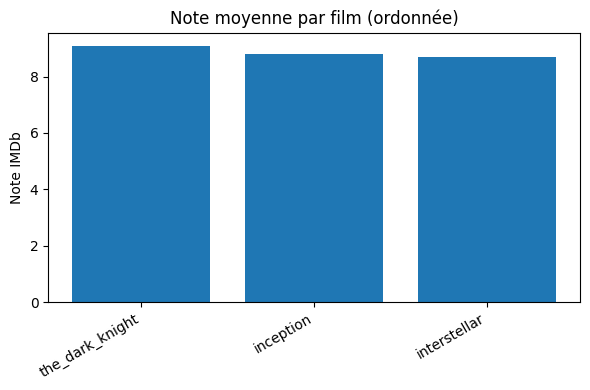

In [25]:
df_sorted = df.sort_values("rating", ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(df_sorted["name"], df_sorted["rating"])
ax.set_ylabel("Note IMDb")
ax.set_title("Note moyenne par film (ordonnée)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
